In [ ]:
import xgboost as xgb
import pandas as pd
import math
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import product
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# download data
filename = f'drive/MyDrive/pitches_folder/pitches.txt'
df = pd.read_csv(filename, dtype={'event3':str,'event4':str})

Mounted at /content/drive


In [ ]:
# converting height into inches
def converted(height):
  feet, inches = map(int, height.split('-'))
  return feet*12+inches
df['b_height'] = df['b_height'].apply(converted)
# data cleaning
df = df.dropna(subset=['pitch_type'])
df = df[~df['pitch_type'].isin(['AB','UN','PO','FO','FA','EP','SC','IN'])]
# dropping irrelevant columns
df = df[['game_pk','inning','top','at_bat_num','pcount_at_bat','pcount_pitcher','balls','strikes','fouls','outs','stand','b_height','pitcher_id','p_throws','away_team_runs','home_team_runs','pitch_type','on_1b','on_2b','on_3b']]
# on base encoding
df['on_1b'] = df['on_1b'].apply(lambda x: 0 if pd.isna(x) else 1)
df['on_2b'] = df['on_2b'].apply(lambda x: 0 if pd.isna(x) else 1)
df['on_3b'] = df['on_3b'].apply(lambda x: 0 if pd.isna(x) else 1)
# handedness encoding
df['stand'] = df['stand'].replace({'L':0,'R':1})
df['p_throws'] = df['p_throws'].replace({'L':0,'R':1})
# global variable x_cols, list of covariates
x_cols = ['inning','top','pcount_at_bat','pcount_pitcher','balls','strikes','fouls','outs','stand','b_height','away_team_runs','home_team_runs','on_1b','on_2b','on_3b']

In [ ]:
# constants etc
df_xgb = df.copy()
df_xgb['pitch_type'].astype('category')
k = 25
value_counts = df['pitcher_id'].value_counts()
values_above_threshold = value_counts[value_counts >= 1000]
pitchers = values_above_threshold.index[0::4]
pitchers = pitchers[12:]
outputs = pd.DataFrame()
outputs['pitcher_id']=pitchers
xgb_acc_vec = []
most_common_vec = []
train_size_vec = []
test_size_vec = []
knn_acc_vec = []

In [ ]:
for pitcher in pitchers:
  temp_df = df_xgb[df_xgb['pitcher_id'] == pitcher]
  temp_df.reset_index(drop=True, inplace=True)
  train_ind = math.ceil(0.8*r44_pitches.shape[0])
  train = temp_df[:train_ind]
  test = temp_df[train_ind:]
  test.reset_index(drop=True, inplace=True)

  most_common = Counter(temp_df['pitch_type'])
  most_common = most_common.most_common(1)[0][0]

  label_encoder = LabelEncoder()
  test['pitch_type'] = label_encoder.fit_transform(test['pitch_type'])
  train['pitch_type'] = label_encoder.fit_transform(train['pitch_type'])
  fb = label_encoder.transform([most_common])

  dtrain = xgb.DMatrix(train[x_cols], label=train['pitch_type'], enable_categorical=True)
  dtest = xgb.DMatrix(test[x_cols], label=test['pitch_type'], enable_categorical=True)
  params = {'objective': 'multi:softmax', 'num_class': len(temp_df['pitch_type'].unique()),'max_depth': 5,'learning_rate': .01,}
  xgb_model = xgb.train(params, dtrain, 100)
  y_pred_xgb = xgb_model.predict(dtest)

  # accuracy analysis
  accuracy_xgb = sum(1 for i in range(len(y_pred_xgb)) if (test['pitch_type']).iloc[i] == y_pred_xgb[i]) / len(y_pred_xgb)
  percent_most_common = sum(1 for i in range(len(y_pred_xgb)) if (test['pitch_type']).iloc[i] == 3) / len(y_pred_xgb)

  xgb_acc_vec = xgb_acc_vec + [accuracy_xgb]
  most_common_vec = most_common_vec + [percent_most_common]
  train_size_vec = train_size_vec + [train.shape[0]]
  test_size_vec = test_size_vec + [test.shape[0]]


<ipython-input-45-8d8c7d8aa597>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pitch_type'] = label_encoder.fit_transform(test['pitch_type'])


(291,)
0.33676975945017185
0.08934707903780069


In [ ]:
for pitcher in pitchers:
  temp_df = df[df['pitcher_id'] == pitcher]
  temp_df.reset_index(drop=True, inplace=True)
  train_ind = math.ceil(0.8*temp_df.shape[0])
  train = temp_df[:train_ind]
  #train = balance(train)

  test = temp_df[train_ind:]
  test.reset_index(drop=True, inplace=True)

  model_knn = KNeighborsClassifier(n_neighbors=k)
  model_knn.fit(train[x_cols], train['pitch_type'])
  y_pred_knn = model_knn.predict(test[x_cols])
  accuracy_knn = sum(1 for i in range(len(y_pred_knn)) if (test['pitch_type']).iloc[i] == y_pred_knn[i]) / len(y_pred_knn)
  knn_acc_vec = knn_acc_vec + [accuracy_knn]

In [ ]:
outputs['train_size']=train_size_vec
outputs['test_size']=test_size_vec
outputs['most_common']=most_common_vec
outputs['knn_accuracy']=knn_acc_vec
outputs['xgb_accuracy']=xgb_acc_vec

In [ ]:
def balance(df):
  most_common = Counter(df['pitch_type']).most_common(1)[0][0]
  second_most_common = Counter(df['pitch_type']).most_common(2)[-1][0]
  most_common_count = (df['pitch_type']==most_common).sum()
  second_most_common_count = (df['pitch_type']==second_most_common).sum()
  to_drop = []
  for ind, row in df.iterrows():
    if (most_common_count <= second_most_common_count):
      break
    else:
      to_drop.append(ind)
      most_common_count -= 1
  df.drop(to_drop)
  df.reset_index(drop=True, inplace=True)
  return df

In [ ]:
print(outputs.head())
print(outputs.shape)

   pitcher_id  most_common  train_size  test_size  knn_accuracy  xgb_accuracy
0      518516     0.322275        2536        633      0.331754      0.368088
1      434643     0.410256        2496        624      0.400641      0.451923
2      453344     0.500000        2482        620      0.501613      0.511290
3      150414     0.559211        2434        608      0.546053      0.565789
4      207267     0.366221        2392        598      0.392977      0.391304
(50, 6)


Analysis


In [ ]:
filename = f'drive/MyDrive/output_file.csv'
df_res = pd.read_csv(filename, dtype={'event3':str,'event4':str})

In [ ]:
results = pd.concat([outputs,df_res],axis=1)
results = results.drop('pitchers', axis=1)
results['RNN_acc'] /= 100
results['Attn_acc']/=100

# calculating percentage improvement over naive
results['xgb_improved'] = (results['xgb_accuracy']-results['most_common'])/results['most_common']
results['seq_improved'] = np.maximum((results['RNN_acc']-results['most_common'])/results['most_common'], (results['Attn_acc']-results['most_common'])/results['most_common'])

# running t-tests
p_hat_xgb = (results['xgb_accuracy']*results['test_size'] + results['most_common']*results['train_size']) / (results['test_size']+results['train_size'])
seq_accuracy = np.maximum(results['RNN_acc'],results['Attn_acc'])
p_hat_seq = (seq_accuracy*results['test_size'] + results['most_common']*results['train_size']) / (results['test_size']+results['train_size'])
df = results['train_size']+results['test_size']-2
t_xgb = (results['xgb_accuracy']-results['most_common']) / np.sqrt(p_hat_xgb*(1-p_hat_xgb)*(1/results['train_size']+1/results['test_size']))
t_seq = (results['xgb_accuracy']-results['most_common']) / np.sqrt(p_hat_xgb*(1-p_hat_xgb)*(1/results['train_size']+1/results['test_size']))
results['p_val_xgb'] = (1-t.cdf(t_xgb,df=df))
results['p_val_seq'] = (1-t.cdf(t_seq,df=df))

KeyError: ignored

(711258, 20)
pitcher_id    448694.000000
RNN_acc            0.308511
Attn_acc           0.340426
Name: 18, dtype: float64


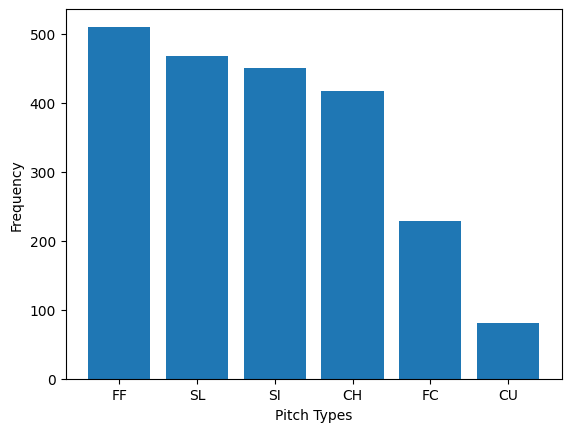

In [ ]:
print(df.shape)

#print(results[results['p_val_xgb']<=.001])
id = results.iloc[18,0]
print(results.iloc[18,:])
r44_pitches = df[df['pitcher_id'] == id]['pitch_type'].value_counts()
plt.bar(r44_pitches.index, r44_pitches.values)
plt.xlabel('Pitch Types')
plt.ylabel('Frequency')
plt.show()

346871
(512, 20)
(291, 20)
pitcher_id    346871.00000
RNN_acc            0.51269
Attn_acc           0.51269
Name: 27, dtype: float64


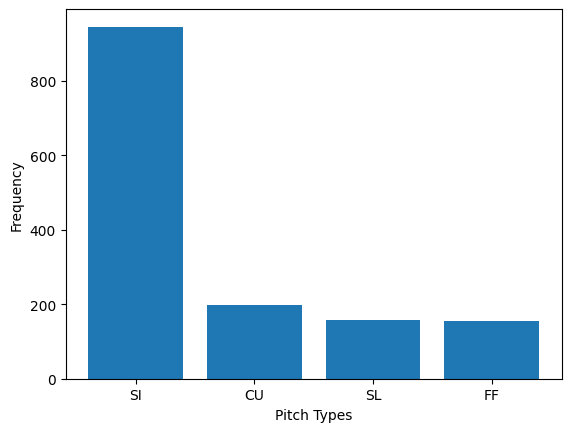

In [ ]:
id = results.iloc[27,0]
print(id)
r44_pitches = df[df['pitcher_id'] == 346871]#['pitch_type'].value_counts()
train_ind = math.ceil(0.8*r44_pitches.shape[0])
train_r44 = r44_pitches[:train_ind]
test_r44 = r44_pitches[train_ind:]
min_count = train_r44['pitch_type'].value_counts().min()
train_r44 = train_r44.groupby('pitch_type').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
train_r44 = train_r44.sample(frac=1, random_state=42)
print(train_r44.shape)
print(test_r44.shape)

print(results.iloc[27,:])

r44_pitches = r44_pitches['pitch_type'].value_counts()
plt.bar(r44_pitches.index, r44_pitches.values)
plt.xlabel('Pitch Types')
plt.ylabel('Frequency')
plt.show()

(376, 20)


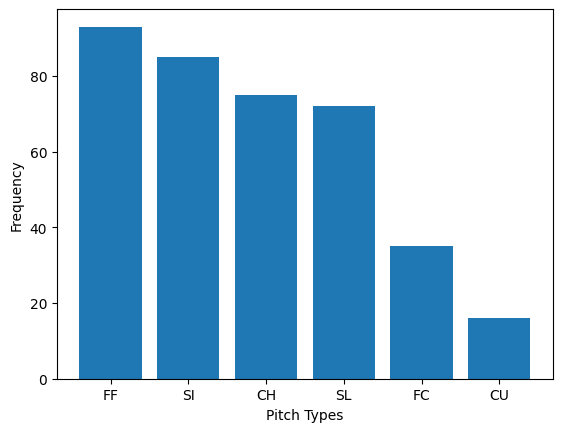

In [ ]:
temp_df = df[df['pitcher_id'] == 448694]
temp_df.reset_index(drop=True, inplace=True)
ngames = temp_df['game_pk'].unique() # number of unique games
train_ind = temp_df[temp_df['game_pk'] == ngames[math.ceil(0.8*len(ngames))]].index[0]
test = temp_df[train_ind:]
print(test.shape)
r44_pitches = test['pitch_type'].value_counts()
plt.bar(r44_pitches.index, r44_pitches.values)
plt.xlabel('Pitch Types')
plt.ylabel('Frequency')
plt.show()

In [ ]:
results.to_csv('drive/MyDrive/stats232results.csv',index=False)

In [ ]:
# Pitchers A and B preprocessing and parameter validating
x_no_seq = ['inning','top','pcount_at_bat','pcount_pitcher','balls','strikes','fouls','outs','stand','b_height','away_team_runs','home_team_runs','on_1b','on_2b','on_3b']
warnings.filterwarnings('ignore')
label_encoder = LabelEncoder()

df_A = df[df['pitcher_id'] == 448694]
df_A.reset_index(drop=True, inplace=True)
max_at_bat_A = df_A['pcount_at_bat'].max()
new_cols_A = ['p1','p2','p3', 'p4','p5','p6','p7','p8','p9','p10', 'p11']
df_A['pitch_type'] = label_encoder.fit_transform(df_A['pitch_type'])
df_A = pd.concat([df_A, seqify(df_A, max_at_bat_A, new_cols_A)], axis=1)
df_A[new_cols_A].astype('category')

df_B = df[df['pitcher_id'] == 346871]
df_B.reset_index(drop=True, inplace=True)
max_at_bat_B = df_B['pcount_at_bat'].max()
new_cols_B = ['p1','p2','p3', 'p4','p5','p6','p7','p8','p9', 'p10']
df_B['pitch_type'] = label_encoder.fit_transform(df_B['pitch_type'])
df_B = pd.concat([df_B, seqify(df_B, max_at_bat_B, new_cols_B)], axis=1)
df_B[new_cols_B].astype('category')

train_ind_A = math.ceil(0.7*df_A.shape[0])
test_ind_A = math.ceil(0.85*df_A.shape[0])
train_A = df_A[:train_ind_A]
valid_A = df_A[train_ind_A:test_ind_A]
test_A = df_A[test_ind_A:]

train_ind_B = math.ceil(0.7*df_B.shape[0])
test_ind_B = math.ceil(0.85*df_B.shape[0])
train_B = df_B[:train_ind_B]
valid_B = df_B[train_ind_B:test_ind_B]
test_B = df_B[test_ind_B:]

print("Validating pitcher A XGB without seqence info")
validate(train_A, valid_A, test_A, x_no_seq)
print("Validating pitcher B XGB without seqence info")
validate(train_B, valid_B, test_B, x_no_seq)
print("Validating pitcher A XGB with seqence info")
validate(train_A, valid_A, test_A, x_no_seq + new_cols_A)
print("Validating pitcher B XGB with seqence info")
validate(train_B, valid_B, test_B, x_no_seq + new_cols_B)

Validating pitcher A XGB without seqence info
Best accuracy on validation set:  0.3931888544891641
Best balancing:  <function weighted_loss at 0x7f29d69aecb0>  Best iteration count:  100  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.01, 'max_depth': 3, 'num_class': 6}
Test accuracy with best parameters: 0.3219814241486068
Validating pitcher B XGB without seqence info
Best accuracy on validation set:  0.6164383561643836
Best balancing:  <function weighted_loss at 0x7f29d69aecb0>  Best iteration count:  50  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.01, 'max_depth': 3, 'num_class': 4}
Test accuracy with best parameters: 0.6192660550458715
Validating pitcher A XGB with seqence info
Best accuracy on validation set:  0.4024767801857585
Best balancing:  <function weighted_loss at 0x7f29d69aecb0>  Best iteration count:  50  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.1, 'max_depth': 3, 'num_class': 6}
Test accuracy with best

2    141
0     41
1     22
3     14
Name: pitch_type, dtype: int64


In [ ]:
# Getting previous pitch information
def seqify(df, max_at_bat, new_cols):
  prev_pitches = np.zeros((df.shape[0], max_at_bat))
  for i in range(0,df.shape[0]):
    for p in range (1,df.loc[i,'pcount_at_bat']):
      if i-p in df.index and df.loc[i-p,'pcount_at_bat'] == df.loc[i,'pcount_at_bat']-p:
        prev_pitches[i,p-1] = df.loc[i-p,'pitch_type']
  return pd.DataFrame(prev_pitches, columns=new_cols)

In [ ]:
# Hyperparameter tuning
def validate(train, valid, test, x_cols):
  learning_rates = [0.01, 0.1, 0.3, 0.5]
  depths = [3, 5, 7]
  iterations = [50, 100, 150]
  balancing_funcs = [no_bal,unif_dist,oversampled,undersampled,weighted_loss]

  best_accuracy = 0
  best_params = {}

  for lr, d, iter, func in product(learning_rates, depths, iterations, balancing_funcs):
      if func == 'weighted_loss':
        params = {'objective': weighted_loss_fn,'learning_rate': lr,'max_depth': d, 'num_class': len(train['pitch_type'].unique())}
      else:
        params = {'objective': 'multi:softmax','learning_rate': lr,'max_depth': d, 'num_class': len(train['pitch_type'].unique())}
      balanced_train = func(train)
      accuracy = run_xgb(balanced_train, valid, params, x_cols, iter)
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_params = params
          best_train = balanced_train
          best_balancing = func
          best_iters = iter

  final_model = run_xgb(best_train, test, best_params, x_cols, best_iters)  # Train on entire training set
  test_accuracy = run_xgb(best_train, test, best_params, x_cols, best_iters)  # Evaluate the final model on the test set
  print("Best accuracy on validation set: ", best_accuracy)
  print("Best balancing: ", best_balancing, " Best iteration count: ", best_iters, " Best parameters:", best_params)
  print("Test accuracy with best parameters:", test_accuracy)


In [ ]:
# XGBoost function, helper for parameter tuning
def run_xgb(train, test, params, x_cols, iters):
  dtrain = xgb.DMatrix(train[x_cols], label=train['pitch_type'], enable_categorical=True)
  dtest = xgb.DMatrix(test[x_cols], label=test['pitch_type'], enable_categorical=True)

  xgb_model = xgb.train(params, dtrain, iters)
  y_pred_xgb = xgb_model.predict(dtest)

  accuracy_xgb = sum(1 for i in range(len(y_pred_xgb)) if (test['pitch_type']).iloc[i] == y_pred_xgb[i]) / len(y_pred_xgb)
  return(accuracy_xgb)

In [ ]:
# Functions for each balancing method we are considering
def no_bal(df):
  return df.copy()

def unif_dist(df):
  min_count = df['pitch_type'].value_counts().min()
  df_copy = df.copy().groupby('pitch_type').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
  return df_copy.sample(frac=1, random_state=42)

def oversampled(df):
  ros = RandomOverSampler(sampling_strategy='auto')
  x_resampled, pitch_type = ros.fit_resample(df.copy().drop(columns=['pitch_type']), df.copy()['pitch_type'])
  return pd.concat([x_resampled, pitch_type], axis=1)

def undersampled(df):
  rus = RandomOverSampler(sampling_strategy='auto')
  x_resampled, pitch_type = rus.fit_resample(df.copy().drop(columns=['pitch_type']), df.copy()['pitch_type'])
  return pd.concat([x_resampled, pitch_type], axis=1)

def weighted_loss(df):
  return df.copy()

def weighted_loss_fn(preds, dtrain):
  labels = dtrain.get_label()
  grad = preds - labels
  hess = np.ones_like(grad)

  label_counts = np.bincount(labels.astype(int))
  label_fractions = 1 - label_counts / len(labels)
  weights = np.array([label_fractions[label] for label in labels])

  grad *= weights
  hess *= weights
  return grad, hess


In [ ]:
# Getting previous pitch information
def seqify_variable(df, n, new_cols):
  prev_pitches = np.zeros((df.shape[0], n))
  for i in range(0,df.shape[0]):
    for p in range (1,n):
      if i-p in df.index and df.loc[i-p,'pcount_at_bat'] == df.loc[i,'pcount_at_bat']-p:
        prev_pitches[i,p-1] = df.loc[i-p,'pitch_type']
  return pd.DataFrame(prev_pitches, columns=new_cols)

In [ ]:
# Validating with varying sequence length
cols = [['p1'],['p1','p2','p3'],['p1','p2','p3','p4','p5'],['p1','p2','p3','p4','p5','p6','p7'],['p1','p2','p3','p4','p5','p6','p7','p8','p9']]

for new_cols in cols:
  n = len(new_cols)

  df_A = df[df['pitcher_id'] == 448694]
  df_A.reset_index(drop=True, inplace=True)
  df_B = df[df['pitcher_id'] == 346871]
  df_B.reset_index(drop=True, inplace=True)
  df_A['pitch_type'] = label_encoder.fit_transform(df_A['pitch_type'])
  df_B['pitch_type'] = label_encoder.fit_transform(df_B['pitch_type'])

  df_A = pd.concat([df_A, seqify_variable(df_A, n, new_cols)], axis=1)
  df_A[new_cols].astype('category')
  df_B = pd.concat([df_B, seqify_variable(df_B, n, new_cols)], axis=1)
  df_B[new_cols].astype('category')

  train_ind_A = math.ceil(0.7*df_A.shape[0])
  test_ind_A = math.ceil(0.85*df_A.shape[0])
  train_A = df_A[:train_ind_A]
  valid_A = df_A[train_ind_A:test_ind_A]
  test_A = df_A[test_ind_A:]

  train_ind_B = math.ceil(0.7*df_B.shape[0])
  test_ind_B = math.ceil(0.85*df_B.shape[0])
  train_B = df_B[:train_ind_B]
  valid_B = df_B[train_ind_B:test_ind_B]
  test_B = df_B[test_ind_B:]

  print("Validating pitcher A XGB, n=", n)
  validate(train_A, valid_A, test_A, x_no_seq+new_cols)
  print("Validating pitcher B XGB, n=", n)
  validate(train_B, valid_B, test_B, x_no_seq+new_cols)


Validating pitcher A XGB, n= 1
Best accuracy on validation set:  0.3931888544891641
Best balancing:  <function no_bal at 0x7c34e70eea70>  Best iteration count:  100  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.01, 'max_depth': 3, 'num_class': 6}
Test accuracy with best parameters: 0.3219814241486068
Validating pitcher B XGB, n= 1
Best accuracy on validation set:  0.6164383561643836
Best balancing:  <function no_bal at 0x7c34e70eea70>  Best iteration count:  50  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.01, 'max_depth': 3, 'num_class': 4}
Test accuracy with best parameters: 0.6192660550458715
Validating pitcher A XGB, n= 3
Best accuracy on validation set:  0.39628482972136225
Best balancing:  <function no_bal at 0x7c34e70eea70>  Best iteration count:  50  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.1, 'max_depth': 3, 'num_class': 6}
Test accuracy with best parameters: 0.35294117647058826
Validating pitcher B XGB, n= 

In [ ]:
n = 3
new_cols = ['p1','p2','p3']
for pitcher in pitchers:
  temp_df = df[df['pitcher_id'] == pitcher]
  temp_df.reset_index(drop=True, inplace=True)
  temp_df['pitch_type'] = label_encoder.fit_transform(temp_df['pitch_type'])
  temp_df = pd.concat([temp_df, seqify_variable(temp_df, n, new_cols)], axis=1)

  train_ind = math.ceil(0.8*temp_df.shape[0])
  train = temp_df[:train_ind]
  test = temp_df[train_ind:]

  params = {'objective': 'multi:softmax', 'num_class': len(temp_df['pitch_type'].unique()),'max_depth': 5,'learning_rate': .01,}
  accuracy = run_xgb(train, test, params, x_no_seq+new_cols, 100)
  print(accuracy)

0.358609794628752
0.47435897435897434
0.46774193548387094
0.569078947368421
0.411371237458194
0.41008403361344536
0.6283783783783784
0.34476843910806176
0.44283121597096187
0.3847583643122677
0.49245283018867925
0.5427435387673957
0.5665322580645161
0.2880658436213992
0.5407098121085595
0.4046610169491525
0.29978586723768735
0.4449438202247191
0.33178654292343385
0.5815602836879432
0.6184538653366584
0.3795811518324607
0.4431818181818182
0.47941176470588237
0.5440729483282675
0.39285714285714285
0.6317567567567568
0.584192439862543
0.6014760147601476
0.5278810408921933
0.44061302681992337
0.44573643410852715
0.3904382470119522
0.6761133603238867
0.5122950819672131
0.39669421487603307
0.38461538461538464
0.34763948497854075
0.7688888888888888
0.6396396396396397
0.6438356164383562
0.4931506849315068
0.5852534562211982
0.5740740740740741
0.5441860465116279
0.5747663551401869
0.7019230769230769
0.3872549019607843
0.4603960396039604
0.725


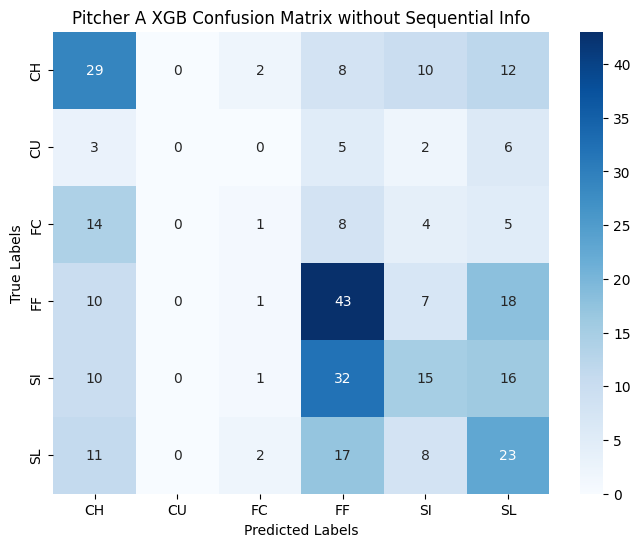

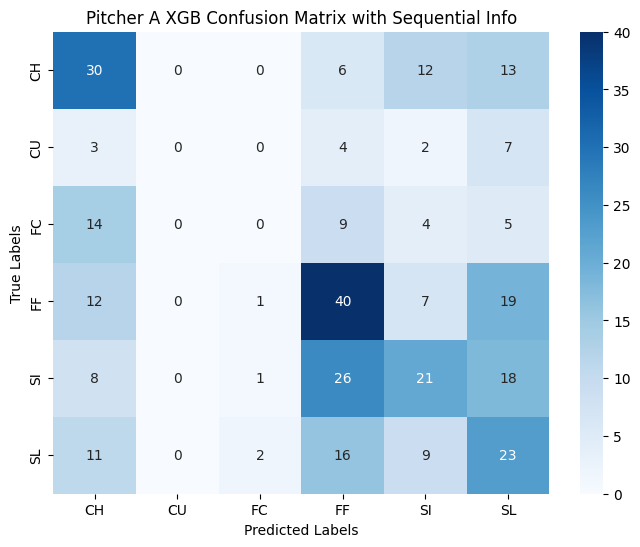

In [ ]:
# Confusion matrices on final XGB models for pitcher A
df_A = df[df['pitcher_id'] == 448694]
new_cols = ['p1','p2','p3']
x_cols = ['inning','top','pcount_at_bat','pcount_pitcher','balls','strikes','fouls','outs','stand','b_height','away_team_runs','home_team_runs','on_1b','on_2b','on_3b']
label_encoder = LabelEncoder()
df_A.reset_index(drop=True, inplace=True)
labels = sorted(df_A['pitch_type'].unique())
df_A['pitch_type'] = label_encoder.fit_transform(df_A['pitch_type'])
df_A = pd.concat([df_A, seqify_variable(df_A, 3, new_cols)], axis=1)
train_ind = math.ceil(0.7*df_A.shape[0])
test_ind = math.ceil(0.85*df_A.shape[0])
train = df_A[:train_ind]
valid = df_A[train_ind:test_ind]
test = df_A[test_ind:]

params_A = {'objective': 'multi:softmax', 'learning_rate': 0.1, 'max_depth': 3, 'num_class': len(df_A['pitch_type'].unique())}
iters_A = 50

dtrain_no_seq = xgb.DMatrix(train[x_cols], label=train['pitch_type'], enable_categorical=True)
dtest_no_seq = xgb.DMatrix(test[x_cols], label=test['pitch_type'], enable_categorical=True)
xgb_model_no_seq = xgb.train(params_A, dtrain_no_seq, iters_A)
preds_no_seq = xgb_model_no_seq.predict(dtest_no_seq)

dtrain_seq = xgb.DMatrix(train[(x_cols+new_cols)], label=train['pitch_type'], enable_categorical=True)
dtest_seq = xgb.DMatrix(test[(x_cols+new_cols)], label=test['pitch_type'], enable_categorical=True)
xgb_model_seq = xgb.train(params_A, dtrain_seq, iters_A)
preds_seq = xgb_model_seq.predict(dtest_seq)

conf_mat_no_seq = confusion_matrix(test['pitch_type'], preds_no_seq)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_no_seq,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Pitcher A XGB Confusion Matrix without Sequential Info")
plt.show()

conf_mat_seq = confusion_matrix(test['pitch_type'], preds_seq)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_seq,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Pitcher A XGB Confusion Matrix with Sequential Info")
plt.show()

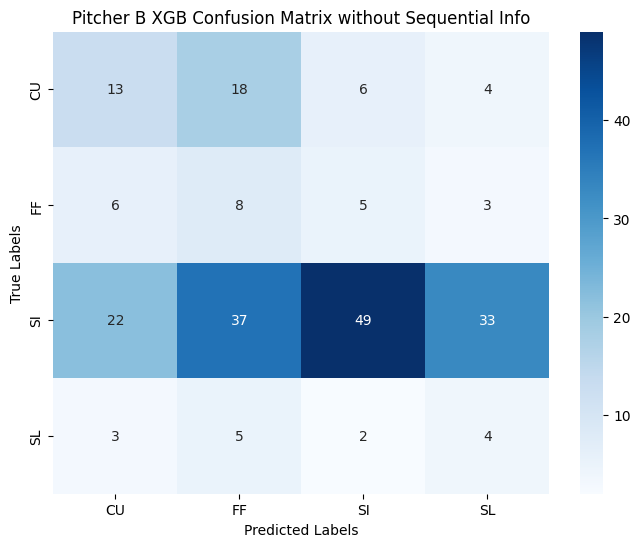

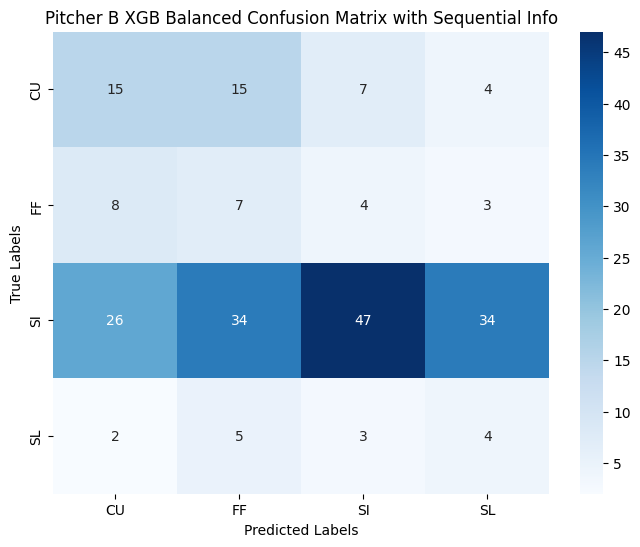

In [ ]:
# Confusion matrices on final XGB models for pitcher B
df_B = df[df['pitcher_id'] == 346871]
labels = sorted(df_B['pitch_type'].unique())
new_cols = ['p1','p2','p3']
x_cols = ['inning','top','pcount_at_bat','pcount_pitcher','balls','strikes','fouls','outs','stand','b_height','away_team_runs','home_team_runs','on_1b','on_2b','on_3b']
label_encoder = LabelEncoder()
df_B.reset_index(drop=True, inplace=True)
df_B['pitch_type'] = label_encoder.fit_transform(df_B['pitch_type'])
df_B = pd.concat([df_B, seqify_variable(df_B, 3, new_cols)], axis=1)
train_ind = math.ceil(0.7*df_B.shape[0])
test_ind = math.ceil(0.85*df_B.shape[0])
train = df_B[:train_ind]
valid = df_B[train_ind:test_ind]
test = df_B[test_ind:]

params_B = {'objective': 'multi:softmax', 'learning_rate': 0.01, 'max_depth': 3, 'num_class': len(df_B['pitch_type'].unique())}
iters_B = 100

dtrain_no_seq = xgb.DMatrix(train[x_cols], label=train['pitch_type'], enable_categorical=True)
dtest_no_seq = xgb.DMatrix(test[x_cols], label=test['pitch_type'], enable_categorical=True)
xgb_model_no_seq = xgb.train(params_B, dtrain_no_seq, iters_B)
preds_no_seq = xgb_model_no_seq.predict(dtest_no_seq)

dtrain_seq = xgb.DMatrix(train[(x_cols+new_cols)], label=train['pitch_type'], enable_categorical=True)
dtest_seq = xgb.DMatrix(test[(x_cols+new_cols)], label=test['pitch_type'], enable_categorical=True)
xgb_model_seq = xgb.train(params_B, dtrain_seq, iters_B)
preds_seq = xgb_model_seq.predict(dtest_seq)

conf_mat_no_seq = confusion_matrix(test['pitch_type'], preds_no_seq)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_no_seq,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Pitcher B XGB Confusion Matrix without Sequential Info")
plt.show()

conf_mat_seq = confusion_matrix(test['pitch_type'], preds_seq)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_seq,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Pitcher B XGB Confusion Matrix with Sequential Info")
plt.show()


In [ ]:
train = train_B
test = test_B
valid = valid_B
x_cols = x_cols+new_cols

balancing_funcs = [no_bal,unif_dist,oversampled,undersampled,weighted_loss]
learning_rates = [0.01]
depths = [3]
iterations = [100]
best_accuracy = 0
best_params = {}

for lr, d, iter, func in product(learning_rates, depths, iterations, balancing_funcs):
    if func == 'weighted_loss':
      params = {'objective': weighted_loss_fn,'learning_rate': lr,'max_depth': d, 'num_class': len(train['pitch_type'].unique())}
    else:
      params = {'objective': 'multi:softmax','learning_rate': lr,'max_depth': d, 'num_class': len(train['pitch_type'].unique())}
    balanced_train = func(train)
    accuracy = run_xgb(balanced_train, valid, params, x_cols, iter)
    print(func, accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_train = balanced_train
        best_balancing = func
        best_iters = iter

final_model = run_xgb(best_train, test, best_params, x_cols, best_iters)  # Train on entire training set
test_accuracy = run_xgb(best_train, test, best_params, x_cols, best_iters)  # Evaluate the final model on the test set
print("Best accuracy on validation set: ", best_accuracy)
print("Best balancing: ", best_balancing, " Best iteration count: ", best_iters, " Best parameters:", best_params)
print("Test accuracy with best parameters:", test_accuracy)


<function no_bal at 0x7f29d69aef80> 0.6210045662100456
<function unif_dist at 0x7f29d69af010> 0.2876712328767123
<function oversampled at 0x7f29d69aedd0> 0.3059360730593607
<function undersampled at 0x7f29d69af130> 0.2831050228310502
<function weighted_loss at 0x7f29d69aecb0> 0.6210045662100456
Best accuracy on validation set:  0.6210045662100456
Best balancing:  <function no_bal at 0x7f29d69aef80>  Best iteration count:  100  Best parameters: {'objective': 'multi:softmax', 'learning_rate': 0.01, 'max_depth': 3, 'num_class': 4}
Test accuracy with best parameters: 0.6238532110091743
